In [1]:
import numpy as xp
from numpy.ma import masked_array
import matplotlib.pyplot as plt

from arte.types.mask import CircularMask
from arte.math.toccd import toccd

from ekarus.e2e.pyramid_wfs import PyramidWFS
from ekarus.e2e.detector import Detector
from ekarus.e2e.utils.zernike_coefficients import create_field_from_zernike_coefficients

In [2]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel='', shrink=1.0):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar(shrink=shrink)
    cbar.ax.set_ylabel(zlabel)

def showZoomCenter(image, pixelSize, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*0.8), int(imageHalfSizeInPoints*1.2)]
    imageZoomedLog= xp.log(image[roi[0]: roi[1], roi[0]:roi[1]])
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)

rad2arcsec = 180/xp.pi*3600
def compute_pixel_size(wavelength, pupil_diameter_in_m, padding=1):
    return wavelength/pupil_diameter_in_m*rad2arcsec/padding

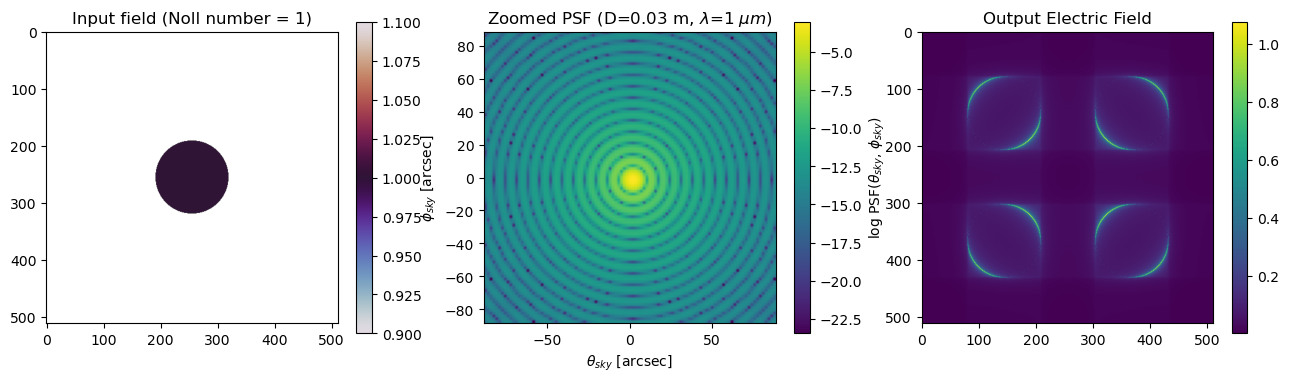

In [3]:
nx = 128

# Create pupil mask
oversampling = 4
mask = CircularMask((oversampling * nx, oversampling * nx), maskRadius=nx // 2)

# Conversions
pupilDiameterInM = 30e-3
lambdaInM = 1000e-9
pix2arcsec = compute_pixel_size(wavelength=lambdaInM, pupil_diameter_in_m=pupilDiameterInM, padding = oversampling)
pix2rad = pix2arcsec/rad2arcsec

# Create the input electric field for flat wavefront (a piston of 1 radians)
noll = 1
zern_amp = 1
input_field = create_field_from_zernike_coefficients(mask, noll, zern_amp)

# Pyramid WFS
apex_angle = 0.005859393655500168#0.00585228309251063#0.0058 # vertex angle in radians, can be tricky to find the right value
wfs = PyramidWFS(apex_angle)

# Electric field propagation
output_field = wfs.propagate(input_field, pix2rad)
intensity = xp.abs(output_field**2)

# Compute normalized psf
psf = xp.abs(xp.abs(wfs.field_on_focal_plane**2))
psf *= 1/xp.sum(psf)

# Plotting results
s = 0.45
plt.figure(1, figsize=(16,9))
plt.subplot(1, 3, 1)
plt.title(f'Input field (Noll number = {noll})')
plt.imshow(xp.angle(input_field), cmap='twilight')
plt.colorbar(shrink=s)

plt.subplot(1, 3, 2)
showZoomCenter(psf, pix2arcsec, title=r'Zoomed PSF (D=%g m, $\lambda$=%g $\mu m$)' % (pupilDiameterInM, lambdaInM*1e6),
               xlabel=r'$\theta_{sky}$ [arcsec]', ylabel=r'$\phi_{sky}$ [arcsec]',
               zlabel=r'log PSF($\theta_{sky}$, $\phi_{sky}$)', shrink=0.45)
# plt.title("PSF on Focal Plane (Intensity) - Log Scale")
# plt.imshow(xp.log( psf ), cmap='inferno')
# plt.colorbar(shrink=s)

plt.subplot(1, 3, 3)
plt.title("Output Electric Field")
plt.imshow(intensity)
plt.colorbar(shrink=s)
plt.show()

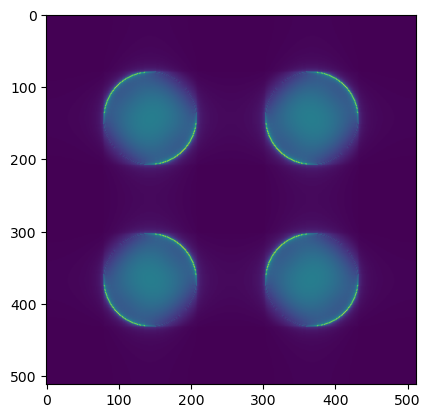

In [4]:
alpha = 3*lambdaInM/pupilDiameterInM

noll = 1
zern_amp = 1
input_field = create_field_from_zernike_coefficients(mask, noll, zern_amp)

modulated_intensity = wfs.modulate(input_field, 9*lambdaInM/pupilDiameterInM, pix2rad)

plt.figure()
plt.imshow(modulated_intensity)



Text(0.5, 1.0, 'Masked Intensity D')

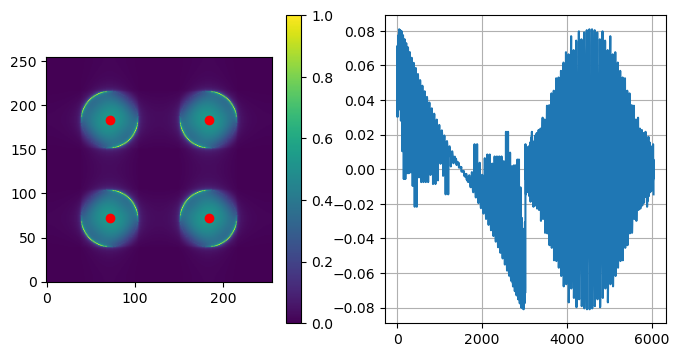

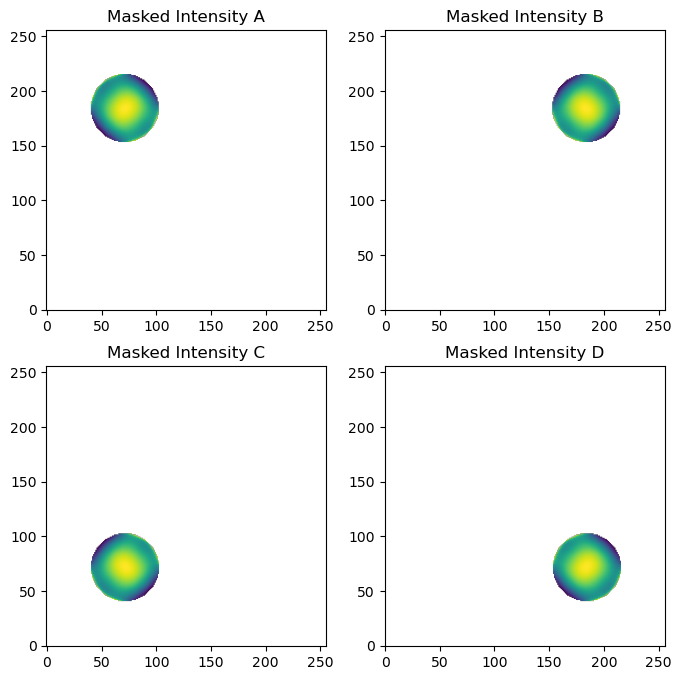

In [5]:
# Initialize detector
detector_shape = (256,256)#(64,64)
ccd = Detector(detector_shape=detector_shape)

ccd_modulated_intensity = toccd(modulated_intensity, ccd.detector_shape)

# Create subaperture masks
ccd.define_subaperture_masks(modulated_intensity, Npix = 63.5)#16)
slope = ccd.compute_slopes(modulated_intensity)


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(ccd_modulated_intensity, origin='lower')
plt.scatter(ccd.subaperture_centers[:,0],ccd.subaperture_centers[:,1],c='red')
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(slope)
plt.grid()


plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.imshow(masked_array(ccd_modulated_intensity, mask=ccd.subapertures[0]), origin='lower')
plt.title("Masked Intensity A")
plt.subplot(2, 2, 2)
plt.imshow(masked_array(ccd_modulated_intensity, mask=ccd.subapertures[1]), origin='lower')
plt.title("Masked Intensity B")
plt.subplot(2, 2, 3)
plt.imshow(masked_array(ccd_modulated_intensity, mask=ccd.subapertures[2]), origin='lower')
plt.title("Masked Intensity C")
plt.subplot(2, 2, 4)
plt.imshow(masked_array(ccd_modulated_intensity, mask=ccd.subapertures[3]), origin='lower')
plt.title("Masked Intensity D")


In [6]:
from  ekarus.e2e.utils.image_utils import get_photocenter

ccd_modulated_intensity = toccd(modulated_intensity,ccd.detector_shape)

ny,nx = ccd.detector_shape

qy,qx = get_photocenter(ccd_modulated_intensity*(1-ccd.subapertures[0]))
print(qy-ny,qx)
qy,qx = get_photocenter(ccd_modulated_intensity*(1-ccd.subapertures[1]))
print(qy-ny,qx-nx)
qy,qx = get_photocenter(ccd_modulated_intensity*(1-ccd.subapertures[2]))
print(qy,qx)
qy,qx = get_photocenter(ccd_modulated_intensity*(1-ccd.subapertures[3]))
print(qy,qx-nx)


print(ccd.subaperture_centers)

diff = ccd.detector_shape[0]-2*xp.abs(qy)
print(diff)
print(wfs.apex_angle*112/diff)


-72.13340516262787 72.13340516262788
-72.13340516262787 -72.13340516262787
72.13340516262787 72.13340516262787
72.13340516262788 -72.13340516262787
[[184.  72.]
 [184. 184.]
 [ 72.  72.]
 [ 72. 184.]]
111.73318967474424
0.005873385440139777


0.7893632325470736


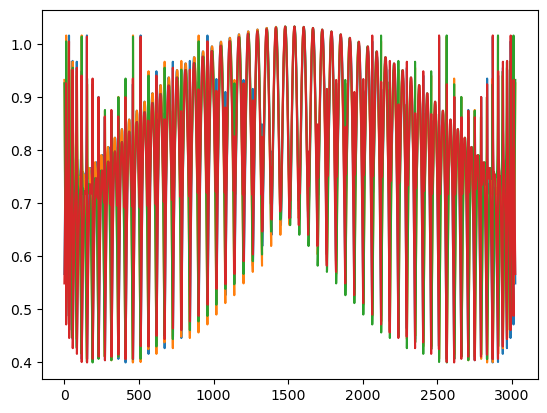

In [7]:
A = ccd_modulated_intensity[~ccd.subapertures[0]]
B = ccd_modulated_intensity[~ccd.subapertures[1]]
C = ccd_modulated_intensity[~ccd.subapertures[2]]
D = ccd_modulated_intensity[~ccd.subapertures[3]]

plt.figure()
plt.plot(A)
plt.plot(B)
plt.plot(C)
plt.plot(D)

mean_intensity = xp.mean(xp.hstack((A,B,C,D)))
print(mean_intensity)


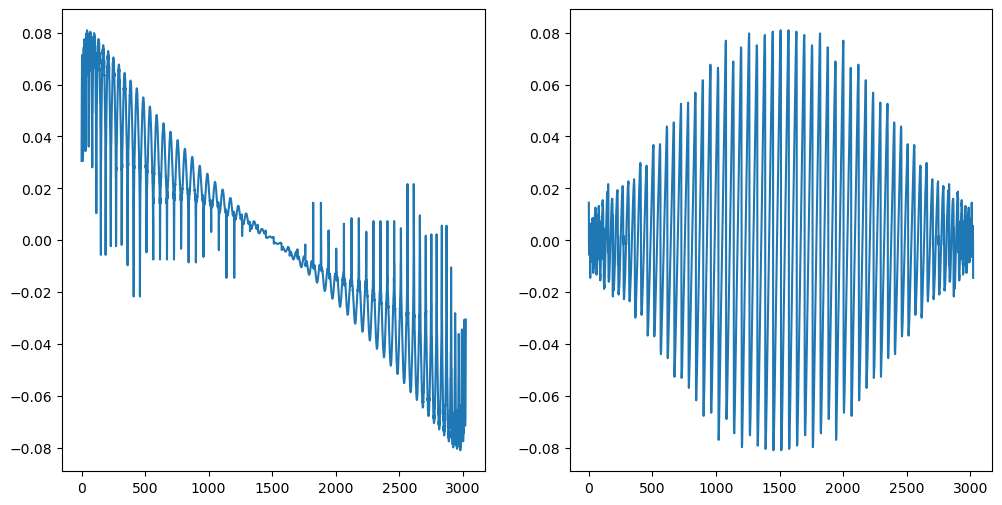

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(((A+B)-(C+D))/mean_intensity)
plt.subplot(1,2,2)
plt.plot(((A+C)-(B+D))/mean_intensity)

In [9]:
# N = xp.size(A)

# AplusB = xp.zeros_like(A)
# CplusD = xp.zeros_like(A)
# AplusC = xp.zeros_like(A)
# BplusD = xp.zeros_like(A)

# for i in range(N):

#     AplusB[i] = A[i]+B[i]
#     CplusD[i] = C[i]+D[i]
#     AplusC[i] = A[i]+C[i]
#     BplusD[i] = B[i]+D[i]


# img = xp.zeros_like(ccd_modulated_intensity)
# img[~ccd.subapertures[2]] = AplusC
# img[~ccd.subapertures[3]] = BplusD

# plt.figure(figsize=(12,12))
# plt.subplot(2,2,1)
# plt.imshow(img.reshape(ccd_modulated_intensity.shape),origin='lower')
# plt.colorbar()
# plt.title('Sum top-bottom')

# plt.subplot(2,2,3)
# plt.imshow(ccd_modulated_intensity,origin='lower')
# plt.colorbar()
# plt.title('Detector image')

# img = xp.zeros_like(ccd_modulated_intensity)
# img[~ccd.subapertures[0]] = AplusB
# img[~ccd.subapertures[2]] = CplusD

# plt.subplot(2,2,4)
# plt.imshow(img.reshape(ccd_modulated_intensity.shape),origin='lower')
# plt.colorbar()
# plt.title('Sum left-right')

# updown = AplusB - CplusD
# leftright = AplusC - BplusD

# img = xp.zeros_like(ccd_modulated_intensity)
# img[~ccd.subapertures[0]] = leftright
# img[~ccd.subapertures[3]] = updown

# plt.subplot(2,2,2)
# plt.imshow(img.reshape(ccd_modulated_intensity.shape),origin='lower')
# plt.colorbar()
# plt.title('Difference')

# plt.figure()
# plt.plot(leftright)
# plt.title('Left right difference')


# plt.figure()
# plt.plot(updown)
# plt.title('Top bottom difference')

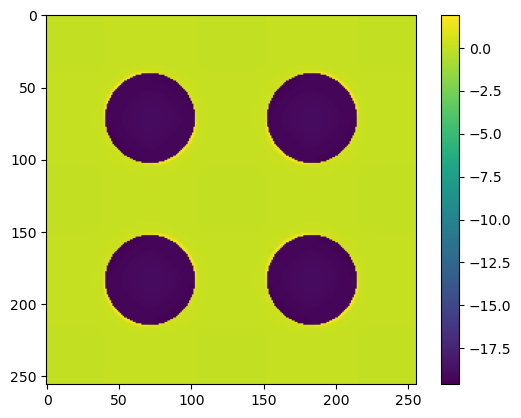

In [10]:
full_mask = xp.zeros_like(ccd_modulated_intensity)
full_mask[~ccd.subapertures[0]] = 1
full_mask[ ~ccd.subapertures[1]] = 1
full_mask[~ccd.subapertures[2]] = 1
full_mask[~ccd.subapertures[3]] = 1

full_mask = xp.reshape(full_mask,ccd_modulated_intensity.shape)

plt.figure()
plt.imshow(full_mask*-20+ccd_modulated_intensity)
plt.colorbar()

# img = full_mask.copy()

# img_ud = xp.flipud(img)
# img_lr = xp.fliplr(img)

# updown = img+img_ud - xp.fliplr(img+img_ud)
# leftright = img+img_lr - xp.flipud(img+img_lr)

# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.imshow(updown,origin='lower')
# plt.colorbar()

# plt.subplot(1,2,2)
# plt.imshow(leftright,origin='lower')
# plt.colorbar()

In [11]:
# Compute slopes for Zernike modes
N = 9
Nmodes = (N-1)*(N-2)//2
IM = xp.zeros((int(xp.size(slope)),Nmodes))
Npix = 128
mask = CircularMask((oversampling * Npix, oversampling * Npix), maskRadius=Npix // 2)

rms_vec = xp.zeros(Nmodes)
zern_amp = 0.1
N0 = 2

for i in range(Nmodes):

    noll = N0 + i
    input_zern = create_field_from_zernike_coefficients(mask, noll, zern_amp)
    rms_vec[i] = xp.std(xp.angle(input_zern[~mask.mask()]))

    modulated_intensity = wfs.modulate(input_zern, alpha, pix2rad)
    zern_slopes = ccd.compute_slopes(modulated_intensity, use_diagonal=False)

    # intensity = wfs.propagate(input_zern)
    # zern_slopes = ccd.compute_slopes(xp.abs(intensity**2))

    IM[:,i] = zern_slopes/zern_amp



Text(0, 0.5, 'STD [radians]')

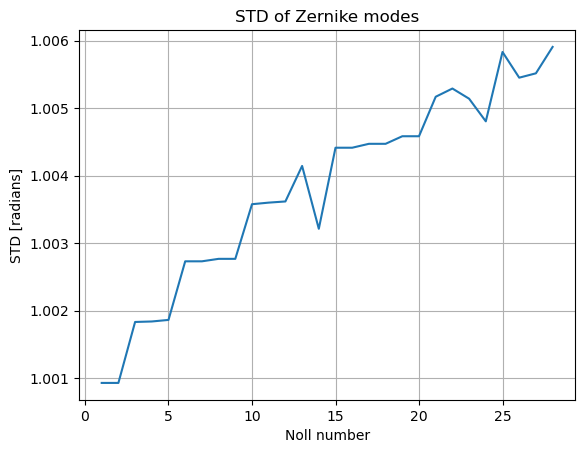

In [12]:
plt.figure()
plt.plot(xp.arange(Nmodes)+1,rms_vec/zern_amp)
plt.grid()
plt.title("STD of Zernike modes")
plt.xlabel("Noll number")
plt.ylabel("STD [radians]")

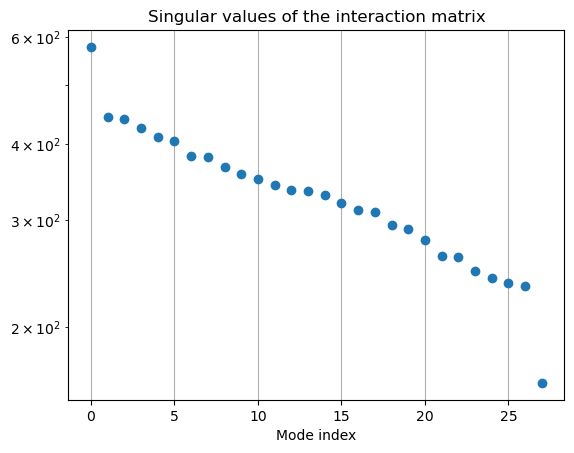

In [13]:
# SVD decomposition of the interaction matrix
U,S,V = xp.linalg.svd(IM, full_matrices=False)

plt.figure()
plt.plot(S,'o')
plt.grid()
plt.title("Singular values of the interaction matrix")
plt.xlabel("Mode index")
plt.yscale('log')

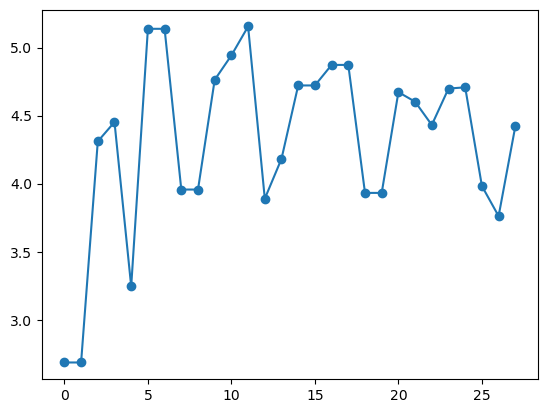

In [14]:
slope_std = xp.std(IM, axis = 0)

plt.figure()
plt.plot(slope_std,'-o')

In [15]:
# plt.figure()
# plt.plot(U[:,0])
# plt.title("First mode of the interaction matrix")

# plt.figure()
# plt.plot(U[:,-1])
# plt.title("Last mode of the interaction matrix")

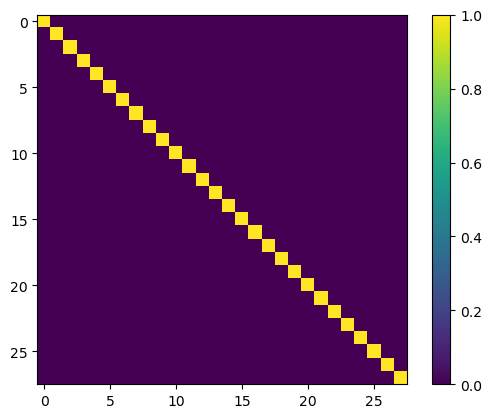

In [16]:
Sinv = 1/S
Rec = (V.T * Sinv) @ U.T

plt.figure()
plt.imshow(Rec @ IM)
plt.colorbar(cmap='inferno')

Text(0.5, 1.0, 'Measured intensity')

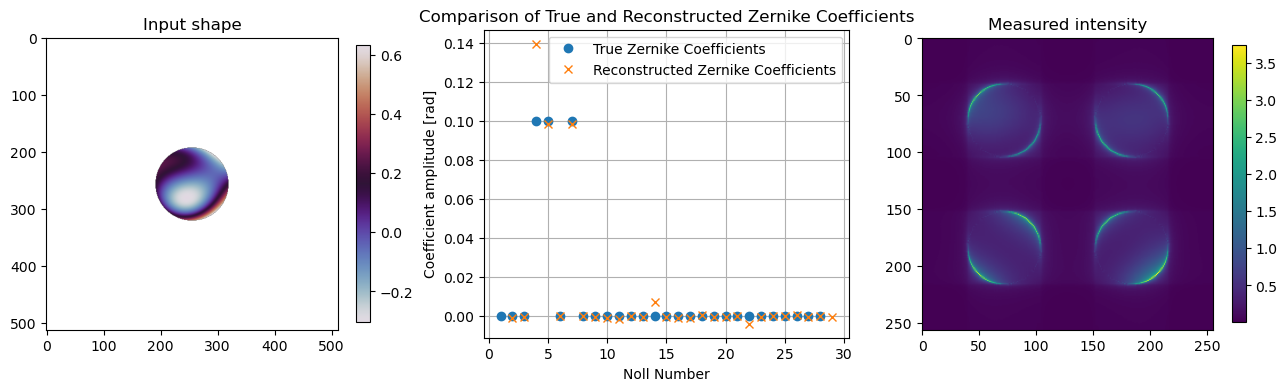

In [17]:
# Test the reconstructor
zids = (4,5,7)
zamps = 0.1
zern_mix = create_field_from_zernike_coefficients(mask, zids, zamps)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(xp.ma.masked_array(xp.angle(zern_mix),mask=mask.mask()), cmap='twilight')
plt.colorbar(shrink=0.9)
plt.title('Input shape')

# Propagate the field through the WFS
# output_field = wfs.propagate(zern_mix/pix2rad)
# output_intensity = xp.abs(output_field**2)
output_intensity = wfs.modulate(zern_mix, alpha, pix2rad)

# Compute slopes
slopes = ccd.compute_slopes(output_intensity,use_diagonal=False)

# Reconstruct the Zernike coefficients
zern_reconstructed = Rec @ slopes
rec_noll_ids = xp.arange(Nmodes)+N0

noll_ids = xp.arange(Nmodes)+1
true_zern = xp.zeros(Nmodes)
true_zern[xp.array(zids)-1] = zamps

plt.subplot(1,3,2)
plt.plot(noll_ids, true_zern, 'o', label='True Zernike Coefficients')
plt.plot(rec_noll_ids, zern_reconstructed, 'x', label='Reconstructed Zernike Coefficients')
plt.xlabel('Noll Number')
plt.ylabel('Coefficient amplitude [rad]')
plt.title('Comparison of True and Reconstructed Zernike Coefficients')
plt.legend(loc='best')
plt.grid()

ccd_intensity = toccd(output_intensity, ccd.detector_shape)

plt.subplot(1,3,3)
plt.imshow(ccd_intensity)
plt.colorbar(shrink=0.9)
plt.title('Measured intensity')


In [18]:
def N_push_pull_calibrate(Nmodes, Npush_pull:int = 2, useDiagonal:bool=False, amp:float = 0.1):
    
    slope_len = int(xp.sum(1-ccd.subapertures[0])*(2+useDiagonal))
    IM = xp.zeros((slope_len,Nmodes))
    mask = CircularMask((oversampling * nx, oversampling * nx), maskRadius=nx // 2)

    push_pull = xp.zeros((slope_len, Npush_pull))

    for i in range(Nmodes):

        noll = 2 + i
        input_zern = create_field_from_zernike_coefficients(mask, noll, amp)

        for j in range(Npush_pull):
            if j % 2 == 1:
                input_field = xp.conj(input_zern)
            else:
                input_field = input_zern.copy()
            modulated_intensity = wfs.modulate(input_field, alpha, pix2rad)
            push_pull[:,j] = ccd.compute_slopes(modulated_intensity, use_diagonal=useDiagonal)/amp*(-1)**j
        
        zern_slopes = (push_pull[:,:-2] + push_pull[:,1:])/2
        IM[:,i] = xp.sum(zern_slopes,axis=1)/Npush_pull

    Rec = xp.linalg.pinv(IM)

    return Rec, IM

In [19]:
# N = 5
# Nmodes = int((N+1)*N/2)
# Npush_pull = 2
# useDiag = False

# Rec,IM = calibrate(Nmodes, Npush_pull, useDiagonal=useDiag)

In [20]:
def push_pull_calibrate(Nmodes, useDiagonal:bool=False, amp:float = 0.1):
    
    slope_len = int(xp.sum(1-ccd.subapertures[0])*(2+useDiagonal))
    IM = xp.zeros((slope_len,Nmodes))
    nx = 128
    mask = CircularMask((oversampling * nx, oversampling * nx), maskRadius=nx // 2)

    for i in range(Nmodes):

        noll = 2 + i

        input_zern = create_field_from_zernike_coefficients(mask, noll, amp)
        modulated_intensity = wfs.modulate(input_zern, alpha, pix2rad)
        push_slope = ccd.compute_slopes(modulated_intensity, use_diagonal=useDiagonal)/amp

        input_zern = xp.conj(input_zern)#create_field_from_zernike_coefficients(mask, noll, -amp)
        modulated_intensity = wfs.modulate(input_zern, alpha, pix2rad)
        pull_slope = ccd.compute_slopes(modulated_intensity, use_diagonal=useDiagonal)/amp

        plt.figure(figsize=(18,5))
        plt.subplot(1,3,1)
        plt.plot(push_slope)
        plt.grid()
        plt.subplot(1,3,2)
        plt.plot(pull_slope)
        plt.title(f'Noll {noll}')
        plt.grid()
        plt.subplot(1,3,3)
        plt.plot((push_slope-pull_slope)/2)
        plt.grid()

        IM[:,i] = (push_slope-pull_slope)/2

    Rec = xp.linalg.pinv(IM)

    return Rec, IM

def calibrate(Nmodes, useDiagonal:bool=False, amp:float = 0.1):
    
    slope_len = int(xp.sum(1-ccd.subapertures[0])*(2+useDiagonal))
    IM = xp.zeros((slope_len,Nmodes))
    nx = 128
    mask = CircularMask((oversampling * nx, oversampling * nx), maskRadius=nx // 2)

    for i in range(Nmodes):

        noll = 2 + i

        input_zern = create_field_from_zernike_coefficients(mask, noll, amp)
        modulated_intensity = wfs.modulate(input_zern, alpha, pix2rad)
        IM[:,i] = ccd.compute_slopes(modulated_intensity, use_diagonal=useDiagonal)/amp

    Rec = xp.linalg.pinv(IM)

    return Rec, IM

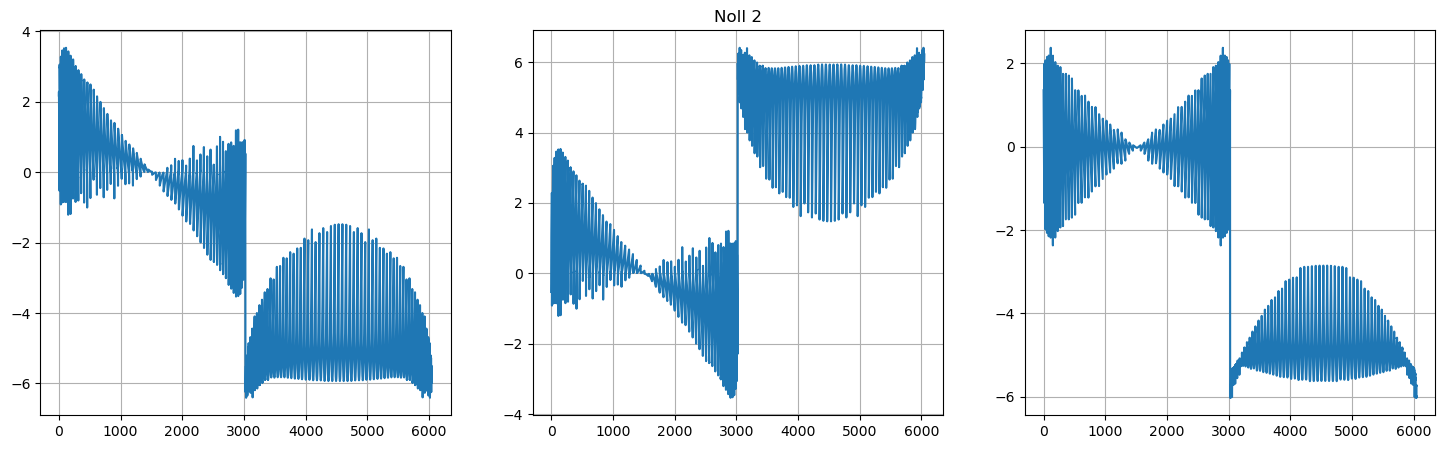

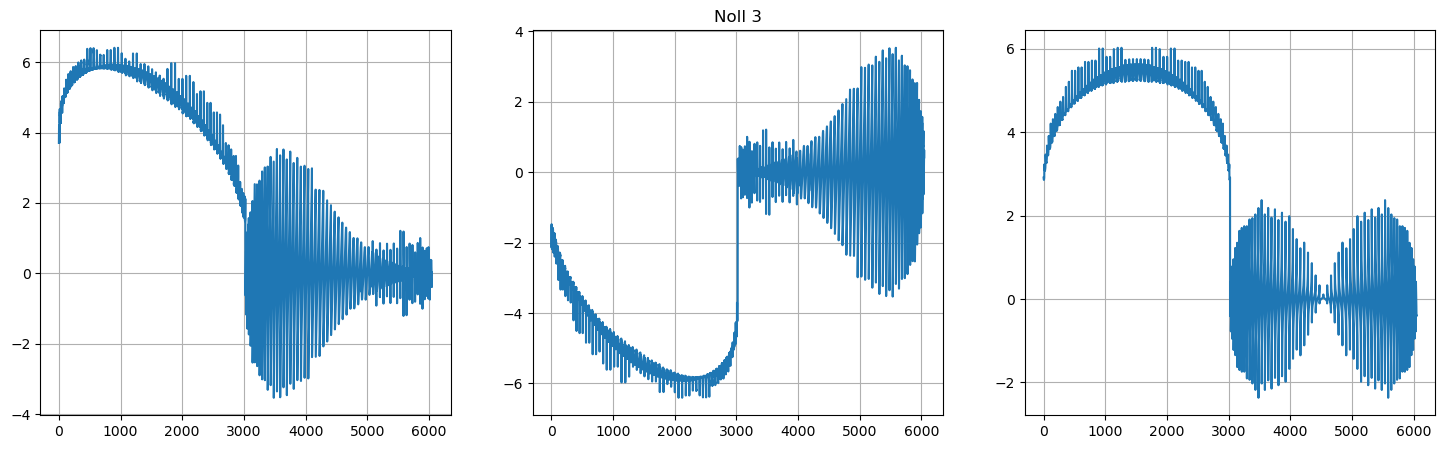

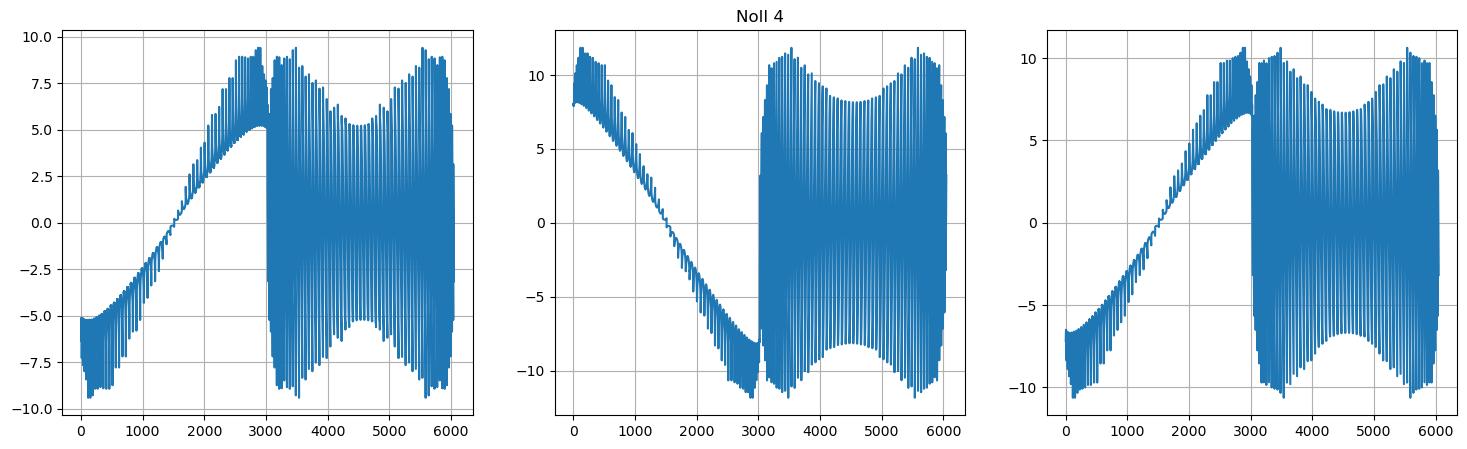

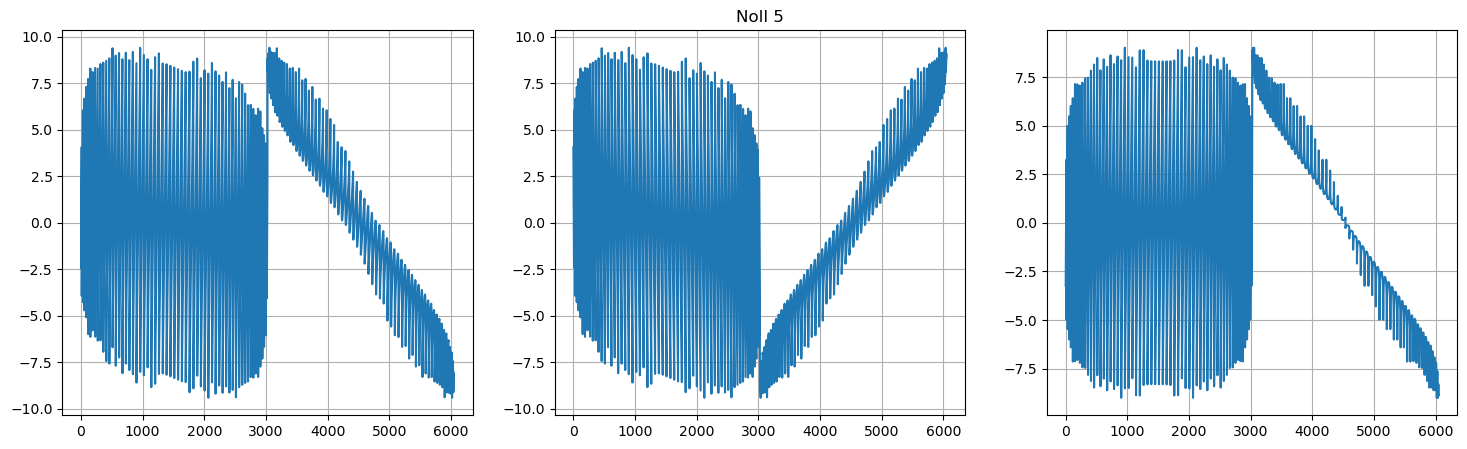

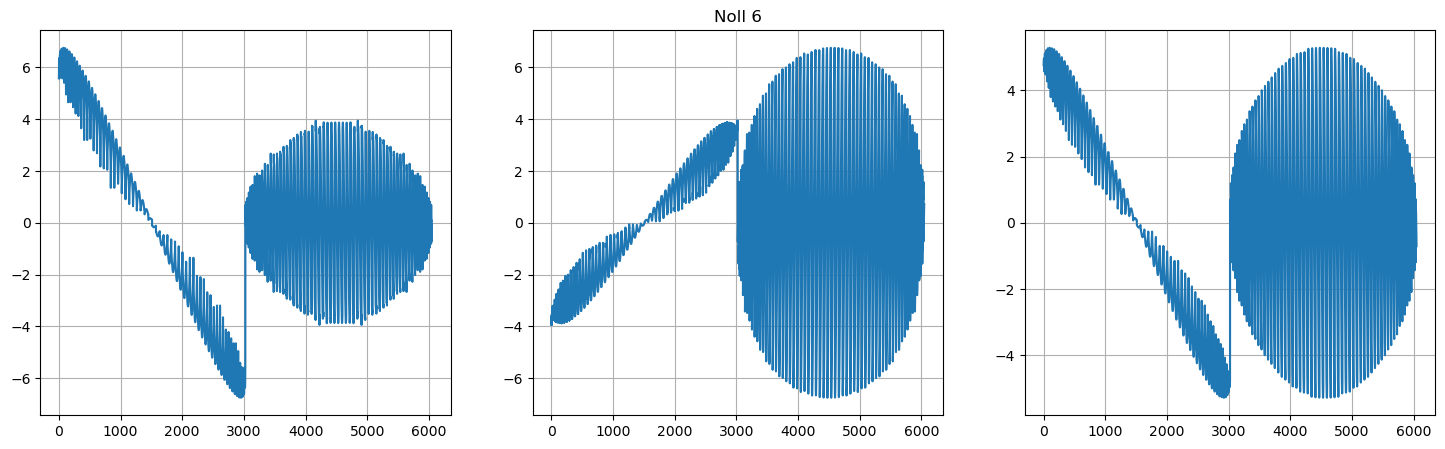

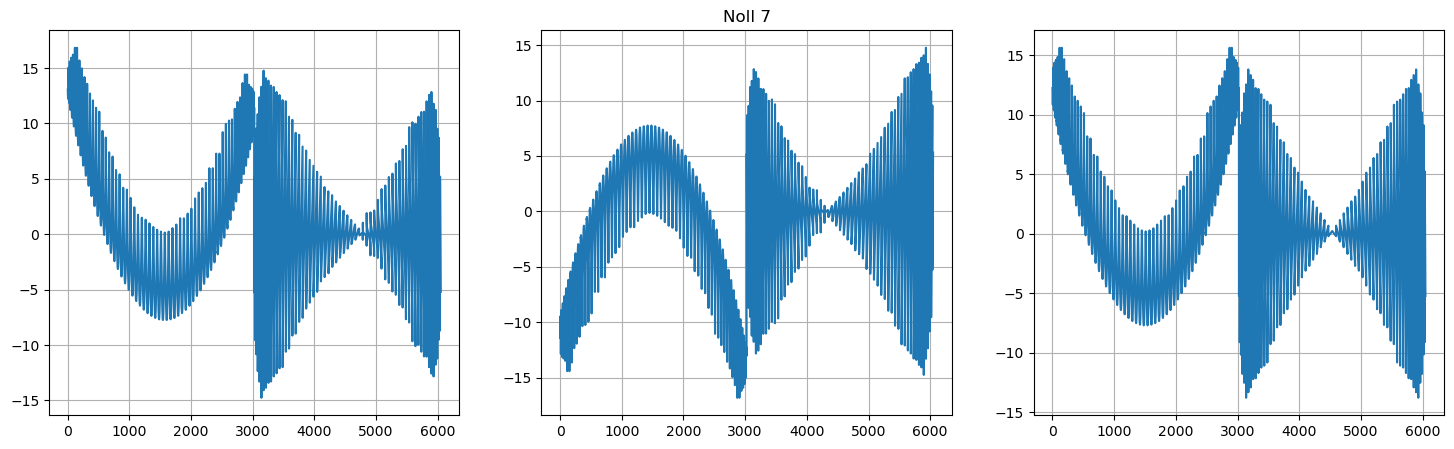

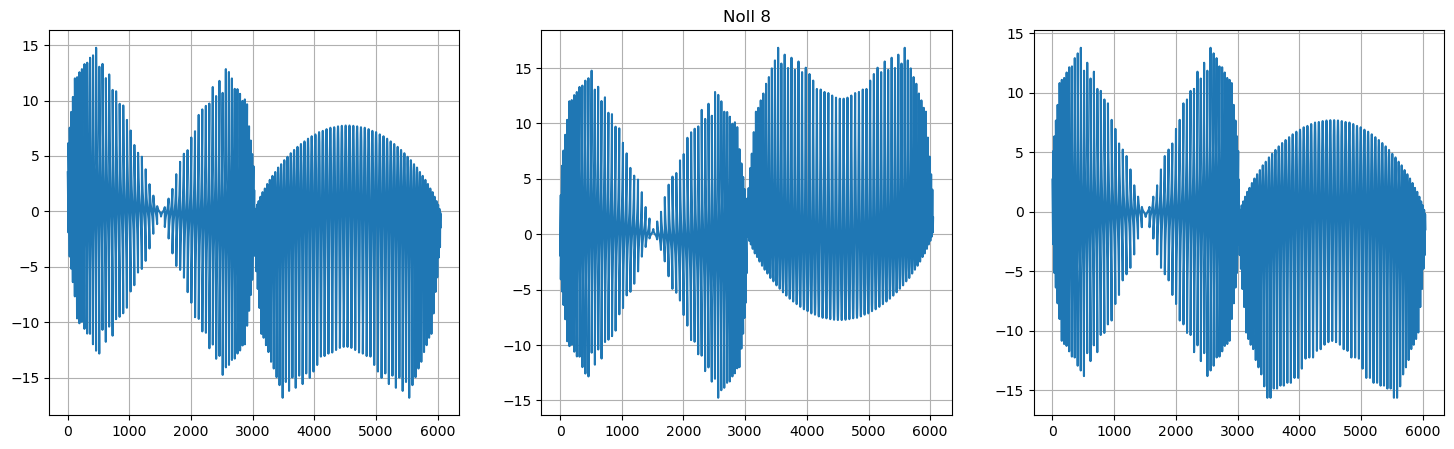

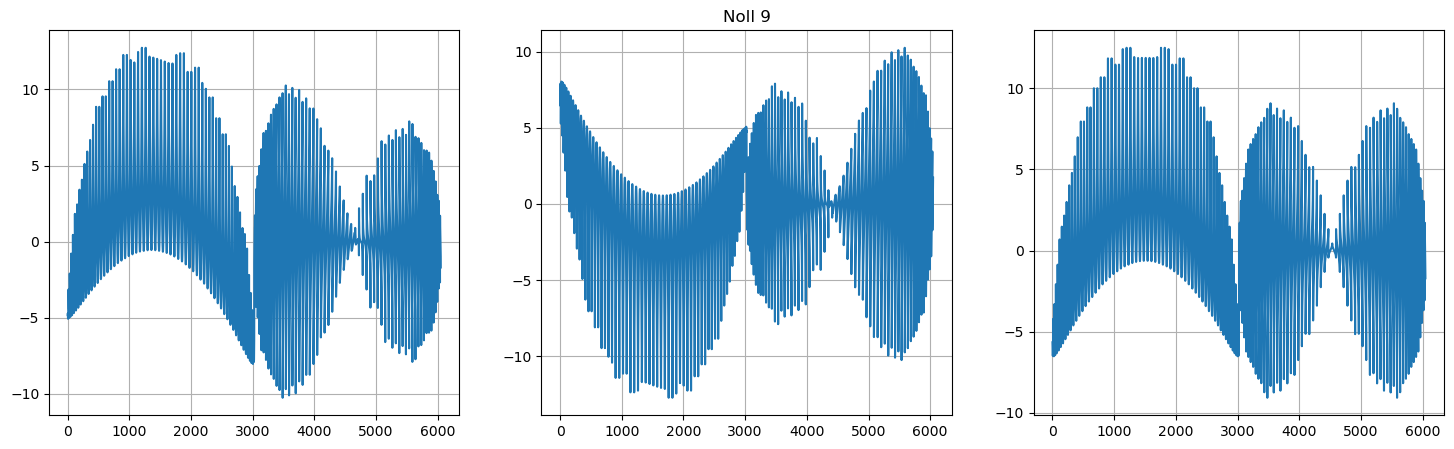

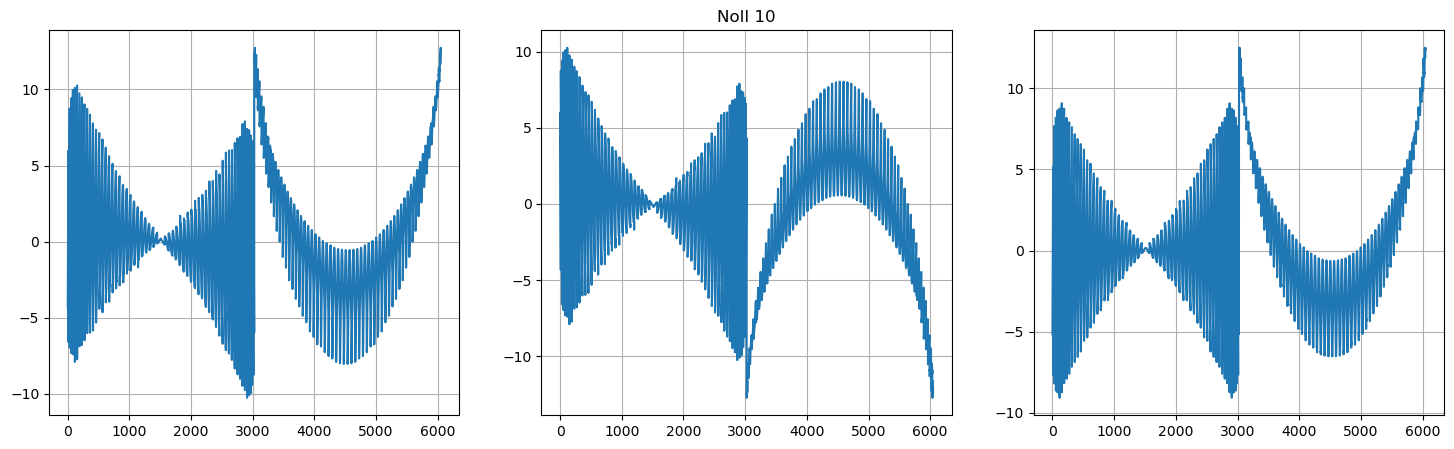

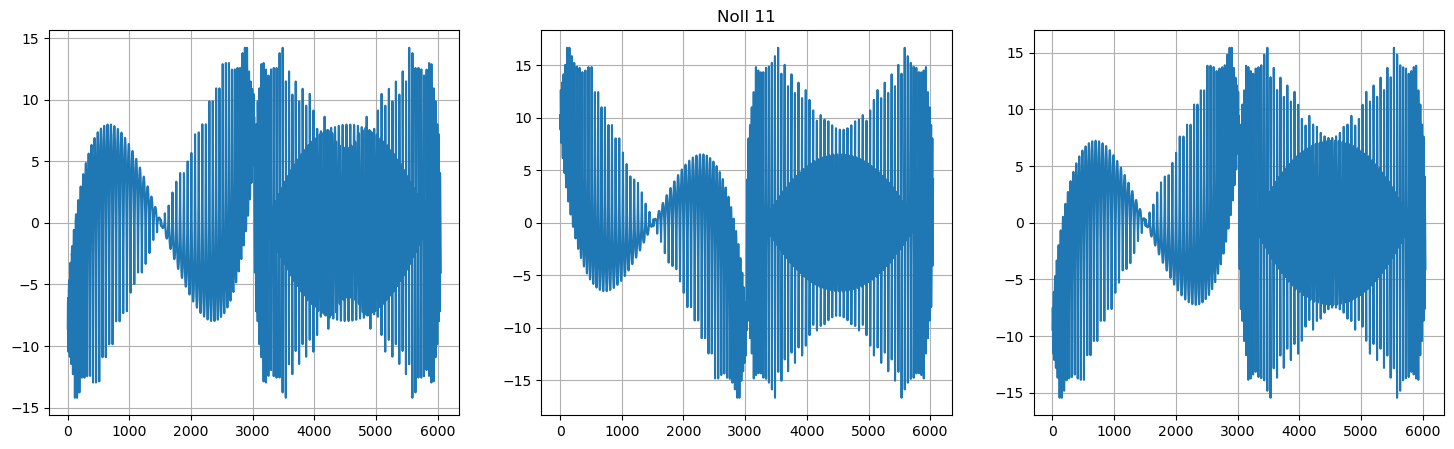

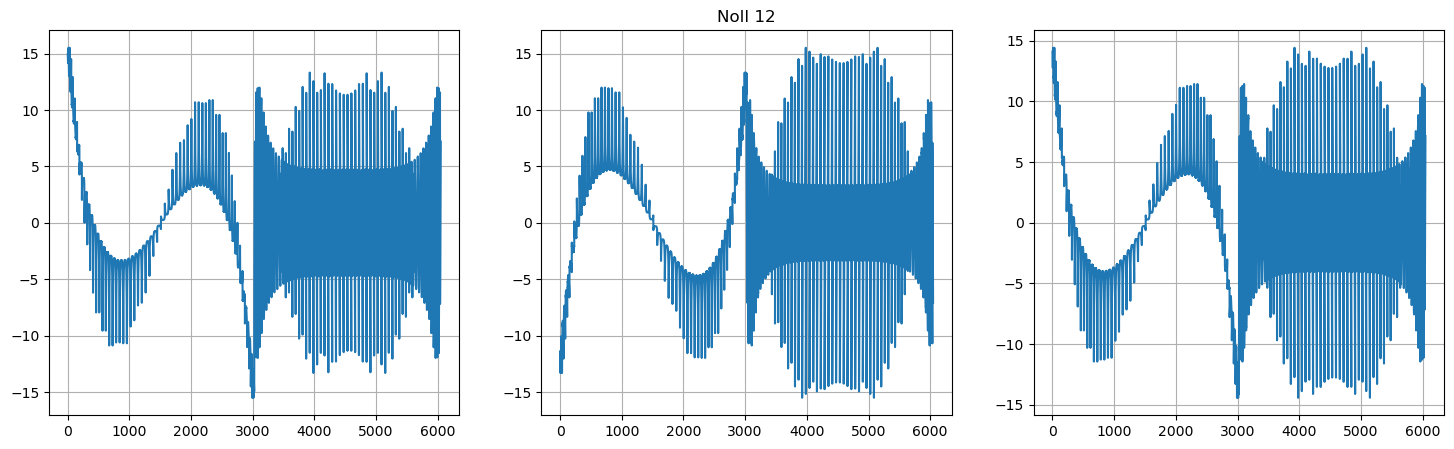

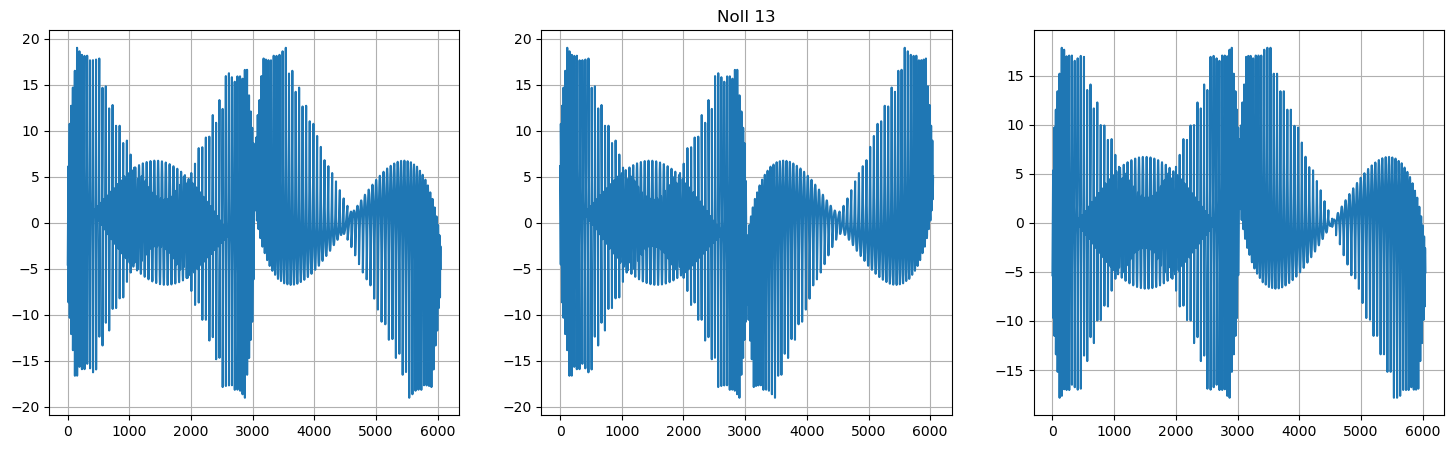

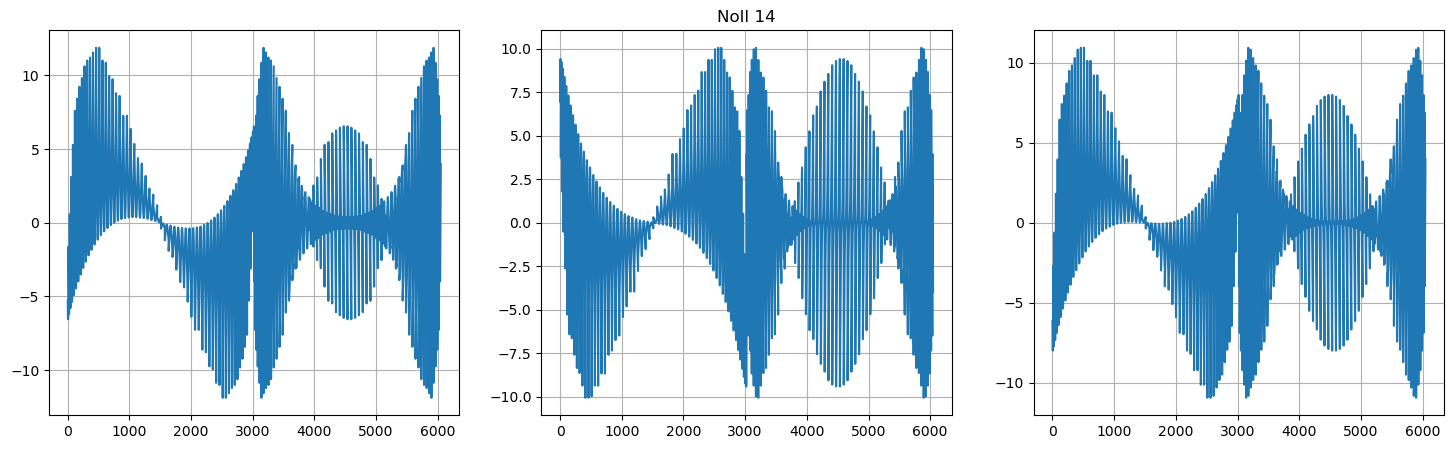

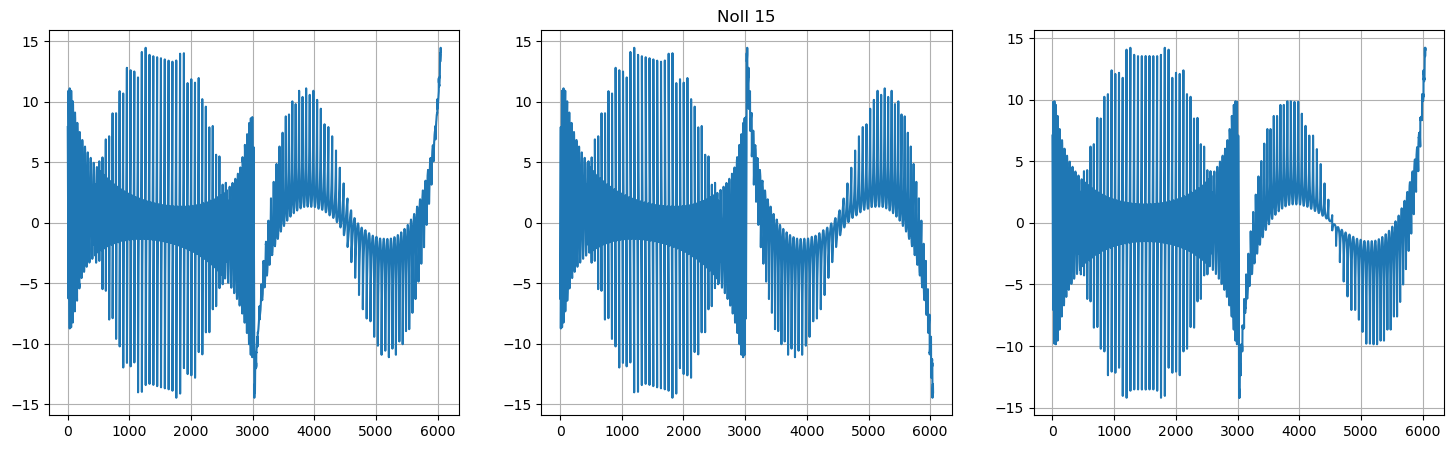

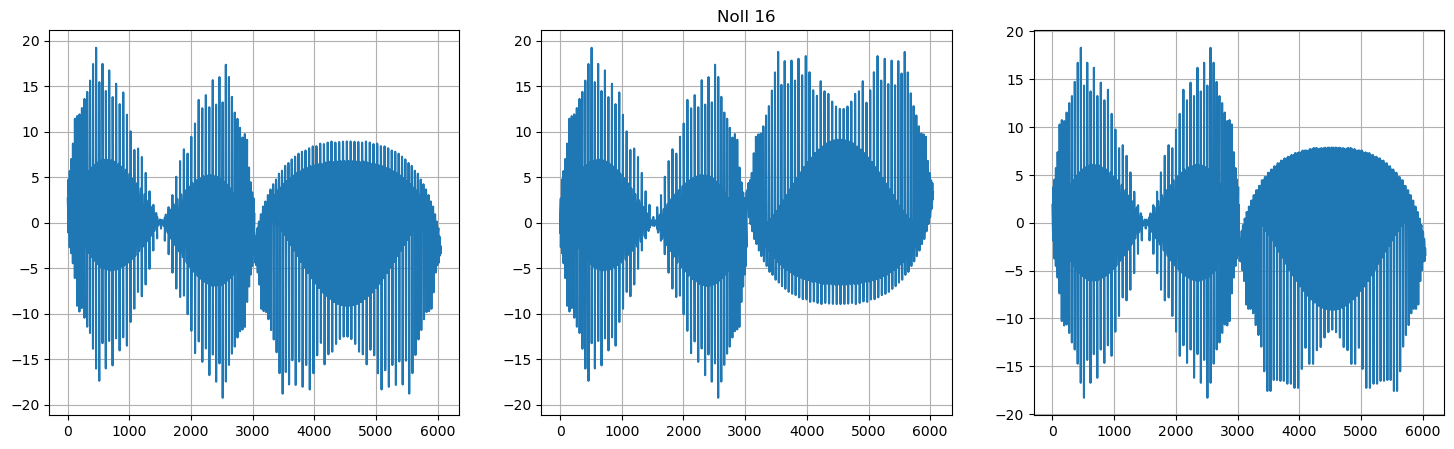

In [21]:
N = 5
Nmodes = int((N+1)*N/2)
useDiag = False

Rec,IM = calibrate(Nmodes, useDiagonal=useDiag)

RecPP,IMpp = push_pull_calibrate(Nmodes, useDiagonal=useDiag)

RecPP2, IMpp2 = N_push_pull_calibrate(Nmodes, Npush_pull=2)

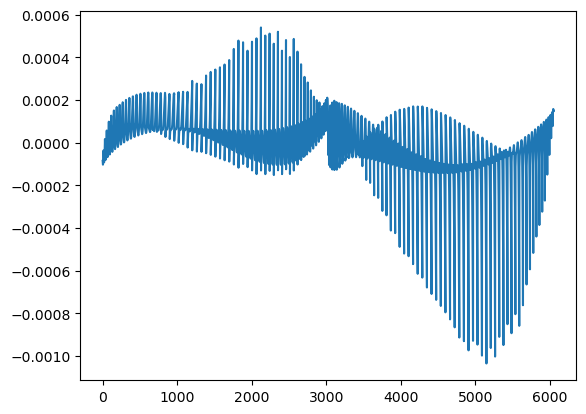

In [26]:
diff = RecPP-RecPP2

plt.plot(xp.sum(diff,axis=0))

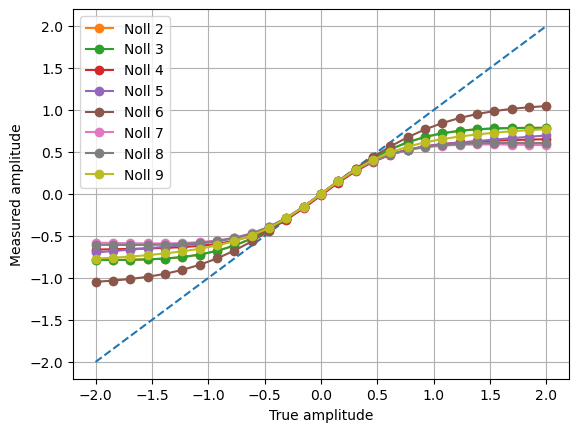

In [23]:
# Linearity check
Nmodes = 8
amp_vec = xp.linspace(-2,2,27,endpoint=True)

plt.figure()
plt.plot(amp_vec,amp_vec,'--')

intensities = xp.zeros((Nmodes,xp.shape(output_intensity)[0],xp.shape(output_intensity)[1]))

for j in range(Nmodes):

    zid = j + 2
    meas_amp = xp.zeros_like(amp_vec)

    for k,amp in enumerate(amp_vec):
        zern = create_field_from_zernike_coefficients(mask, zid, amp)
        output_intensity = wfs.modulate(zern, alpha, pix2rad)
        slopes = ccd.compute_slopes(output_intensity, use_diagonal=useDiag)
        zern_reconstructed = RecPP @ slopes

        meas_amp[k] = zern_reconstructed[j]
    
    intensities[j,:,:] = output_intensity

    plt.plot(amp_vec, meas_amp,'-o', label=f'Noll {zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.grid(True)
        

# plt.xlim([-0.1,0.1])
# plt.ylim([-0.1,0.1])

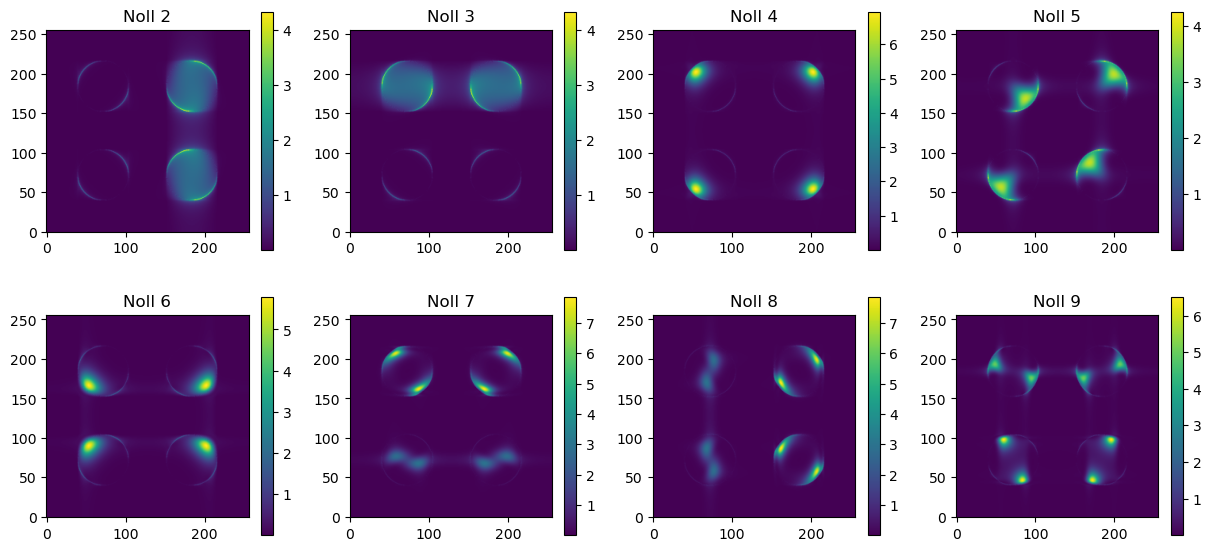

In [24]:
# Plot the intensity on the detector for the last iteration
n_rows = Nmodes//4+1
plt.figure(figsize=(15,3.5*n_rows))

for i in range(Nmodes):
    plt.subplot(n_rows,4,i+1)

    # plt.imshow((intensities[i,:,:]),origin='lower')
    plt.imshow(toccd(intensities[i,:,:],ccd.detector_shape),origin='lower')
    plt.colorbar()
    plt.title(f'Noll {i+2}')